# Почасовое потребление электроэнергии в США

### О наборе данных

Данные о почасовом потреблении энергии PJM

Компания PJM Interconnection LLC (PJM) является региональной организацией по передаче электроэнергии (RTO) в Соединенных Штатах. Это часть сети Eastern Interconnection, управляющей системой передачи электроэнергии, обслуживающей все или части штатов Делавэр, Иллинойс, Индиана, Кентукки, Мэриленд, Мичиган, Нью-Джерси, Северная Каролина, Огайо, Пенсильвания, Теннесси, Вирджиния, Западная Вирджиния и округ Колумбия.

Данные о почасовом потреблении электроэнергии приводятся на веб-сайте PJM в мегаваттах (МВт).

С течением времени регионы менялись, поэтому данные могут отображаться только на определенные даты для каждого региона.

### Задача:

Разработать модель прогноза почасового потребления электроэнергии в одном из регионов США на основе исторических данных, с целью повышения точности краткосрочного планирования нагрузки.

Для начала проведем анализ по одному региону - PJM East (восточные зоны PJM (агрегированные данные)).

In [ ]:
# Базовые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Для параллельных вычислений
import concurrent
from concurrent.futures import ThreadPoolExecutor

# Статистический анализ и временные ряды
from statsmodels.tsa.seasonal import seasonal_decompose

# Кастомные функции
from functions import (
    check_adfuller, 
    check_acf_pacf,
    train_test_split,
    plot_forecast,
    run_sarimax,
    run_prophet,
    evaluate
)

# Визуализация
%matplotlib inline
sns.set_palette("muted")

Importing plotly failed. Interactive plots will not work.


# Загрузка и базовый EDA

<Axes: title={'center': 'PJM Load (совокупная нагрузка)'}, xlabel='Datetime'>

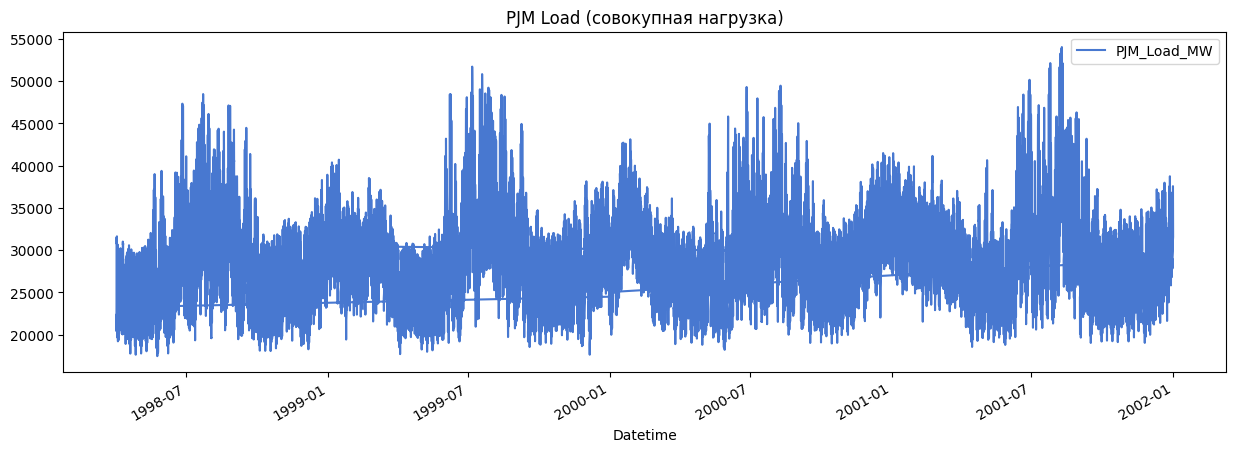

In [2]:
pjm_df = pd.read_csv('Data/PJM_Load_hourly.csv', parse_dates=['Datetime'], index_col=['Datetime'])
pjm_df.plot(figsize=(15,5), title='PJM Load (совокупная нагрузка)')

# Вывод: 

График показывает ярко выраженную __сезонность и тренд__, особенно в летние месяцы.

In [3]:
# Проверяем формат и структуру
display(pjm_df.head())
display(pjm_df.info())

,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-12-31 01:00:00 to 2001-01-02 00:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1)
memory usage: 514.0 KB


None

PJM_Load_MW    0
dtype: int64

<Axes: title={'center': 'Пропущенные значения по дням'}, xlabel='Datetime'>

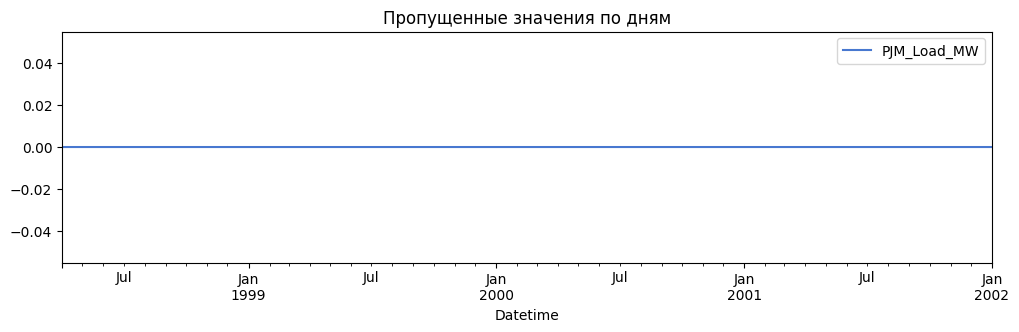

In [4]:
# Проверяем на пропуски
display(pjm_df.isna().sum())
# Как часто есть пропуски и где
pjm_df.isna().resample('D').sum().plot(title='Пропущенные значения по дням', figsize=(12, 3))

# Вывод:

Datetime установлен корректно, все значения типизированны как float64 и самое главное нет пропусков.

In [5]:
# Проверяем, что временные метки действительно почасовые и не имеют разрывов
intervals = pjm_df.index.to_series().diff().value_counts().sort_index()
display(intervals)

Datetime
-2 days +01:00:00     1367
0 days 01:00:00      31517
0 days 02:00:00          8
638 days 01:00:00        1
729 days 01:00:00        2
Name: count, dtype: int64

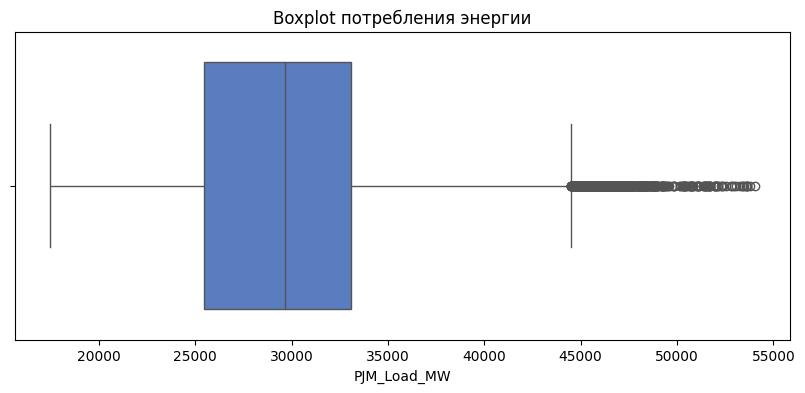

In [6]:
# Проверка на выбросы
plt.figure(figsize=(10, 4))
sns.boxplot(x=pjm_df['PJM_Load_MW'])
plt.title('Boxplot потребления энергии')
plt.show()

# Вывод: 

Медиана потребления находится около 30 000 МВт. Межквартильный размах — приблизительно от 25 000 до 35 000 МВт. Выбросы начинаются примерно с выше 45 000 МВт (это могут быть летние пики нагрузки (например, в июле при жаре).

# Декомпозиция и стационарность

In [7]:
# Проверим стационарность данных
check_adfuller(pjm_df, 'PJM_Load_MW')

ADF statistic: -14.496714853893808
p-value: 6.024269615142964e-27
Критическое значение 1%: -3.4305491234409735
Критическое значение 5%: -2.8616280074583162
Критическое значение 10%: -2.566816843635725
Ряд стационарен (по ADF)


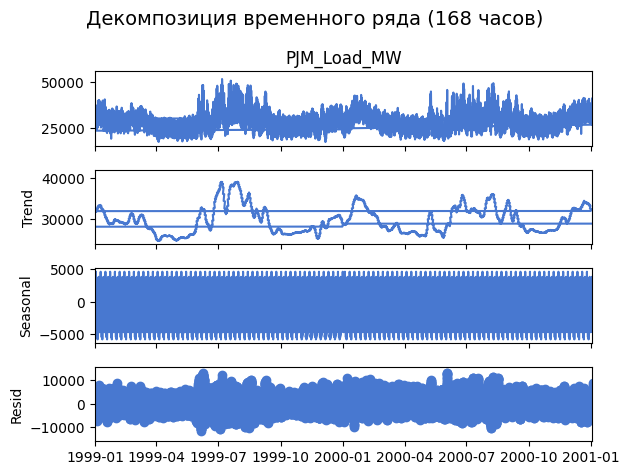

In [8]:
# Проведем декомпозицию временного ряда
# Укажем период — для недельной сезонности в почасовых данных:
decomposition = seasonal_decompose(pjm_df['PJM_Load_MW'], model='additive', period=168)

# Построим график
fig = decomposition.plot()
plt.suptitle('Декомпозиция временного ряда (168 часов)', fontsize=14)
plt.tight_layout()
plt.show()

# Вывод:

* Из оригинального ряда видна ярко выраженная волатильность с регулярными циклами.
* Trend	- Есть колебания по неделям и месяцам — можно увидеть летние пики и зимние спады
* Seasonal - Чёткая, плотная недельная сезонность (168 часов) — характерно для энергопотребления
* Остатки содержат шум, но не слишком выраженный — значит, модель сезонности хорошо объясняет поведение ряда.

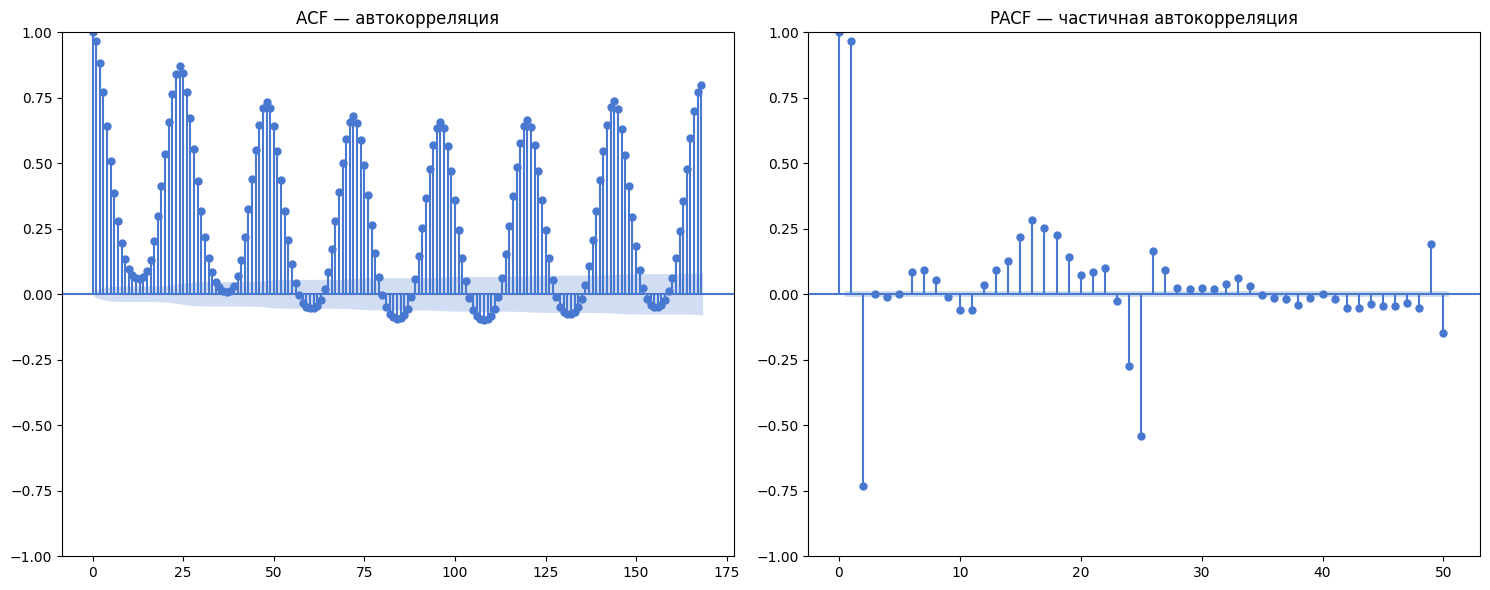

In [9]:
# Проверим ACF/PACF
check_acf_pacf(pjm_df, lags_acf=168, lags_pacf=50, title='PJM_Load_MW')

# Вывод:

* ACF (автокорреляция) явно выраженная периодичность примерно каждые 24 и 168 лагов. Видны колебания, которые соответствуют дневной и недельной сезонности.
* PACF (частичная автокорреляция) первый лаг явно является значимым, некоторые выбросы на лаге от 7 до 15.

Далее возникает вопрос стоит ли делать в данном случае дополнительную предобработку. Поскольку тренд и сезонность явно выраженны и декомпонированы, но они не мешают таким моделям как SARIMAX и Prophet (умеют работать с сезонными рядами напрямую), также в данных нет проблем с нестационарностью. Ресемплирование с дней на недели тоже не требуется. Пропусков нет и все выбросы являются естественными (это сезоны жары и холода, потребление электроэнергии растет).

# Моделирование

Переходим к моделированию моделей. В качестве моделей было принято решения использовать две:
* SARIMAX
* Prophet

Учитывая полученные данные выше для начала можно попробовать следующие настройки для модели __SARIMA__:

### Основной порядок (order=(p, d, q))

* p = 1 или 2 — лаги PACF

* d = 0 — ряд стационарен по ADF

* q = 1 — ACF показывает экспоненциальное затухание

### Сезонный порядок (seasonal_order=(P, D, Q, s))

* s = 24 — дневная сезонность (лучше для короткосрочных прогнозов)

* s = 168 — недельная сезонность (лучше для долгосрочных прогнозов)

Весь запуск моделей, отображение графиков и метрики реализованы в __один пайплайн__.

In [10]:
P = 1 # PACF
D = 0 # ACF
Q = 1

In [11]:
pjm_df = pjm_df.sort_index()  # сделать индекс монотонным
pjm_df = pjm_df.asfreq('h')   # задать частоту (почасовая)

# Горизонты планирования (24, 48 часов)

Примечание: Поскольку вычисления занимают достаточно много времени, было принято решение сделать параллельные вычисления для моделей, чтобы немного сократить время обработки и сохранение каждого прогноза в отдельный файл (всего 6 файлов с прогнозами).

In [ ]:
# Убедимся, что папка для сохранения есть
os.makedirs("Predictions", exist_ok=True)

forecast_horizons = [24, 48]

# Основной цикл с параллельным запуском
for S in forecast_horizons:
    print(f"\n====== Прогноз на {S} часов ======\n")
    train, test = train_test_split(pjm_df, test_size=S)

    # Параметры модели
    order = (P, D, Q)
    seasonal_order = (P, D, Q, S)
    prophet_config = {
        "daily_seasonality": True,
        "weekly_seasonality": True,
        "seasonality_mode": "additive"
    }

    with ThreadPoolExecutor() as executor:
        fut_sarimax = executor.submit(run_sarimax, train, test, S, order, seasonal_order, maxiter=50)
        fut_prophet = executor.submit(run_prophet, train, test, S, prophet_config)

        for future in concurrent.futures.as_completed([fut_sarimax, fut_prophet]):
            model_name, horizon, forecast, mae, rmse, mape = future.result()
            
            print(f" {model_name} ({horizon}ч): MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2%}")
            
            # === Сохранение прогноза ===
            forecast_df = pd.DataFrame({
                'Datetime': forecast.index,
                'Forecast': forecast.values
            })
            filename = f"Predictions/{model_name}_forecast_{horizon}h.csv"
            forecast_df.to_csv(filename, index=False)
            print(f"Сохранён прогноз в файл: {filename}")

# Загрузка и чтение прогнозов 

In [15]:
pred_24_sarimax = pd.read_csv('Predictions/SARIMAX_forecast_24h.csv')
pred_24_prophet = pd.read_csv('Predictions/Prophet_forecast_24h.csv')
pred_48_sarimax = pd.read_csv('Predictions/SARIMAX_forecast_48h.csv')
pred_48_prophet = pd.read_csv('Predictions/Prophet_forecast_48h.csv')

predictions = {
    "pred_24_sarimax": pred_24_sarimax,
    "pred_24_prophet": pred_24_prophet,
    "pred_48_sarimax": pred_48_sarimax,
    "pred_48_prophet": pred_48_prophet,
}

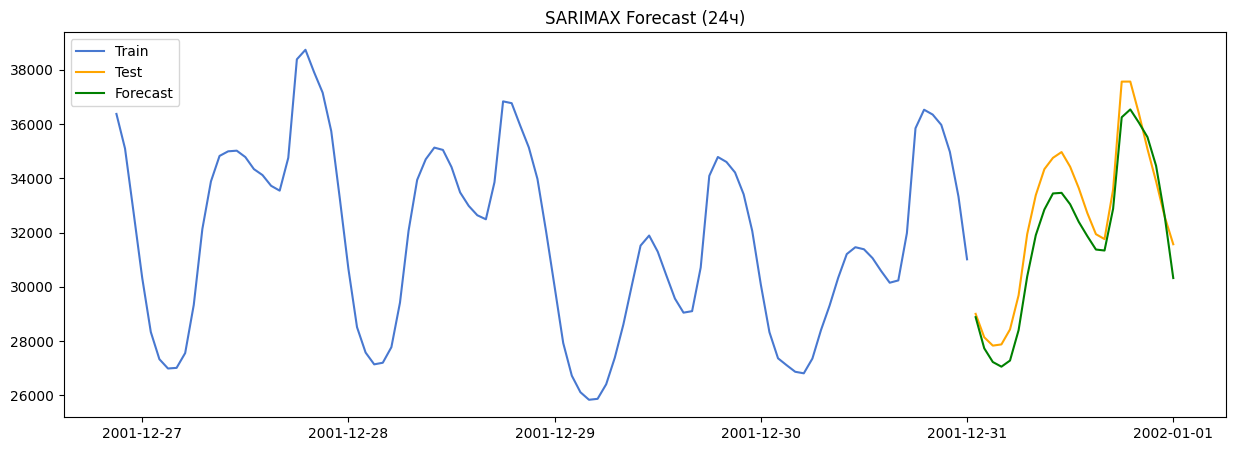

SARIMAX | 24ч → MAE=911.66, RMSE=1024.70, MAPE=2.78%


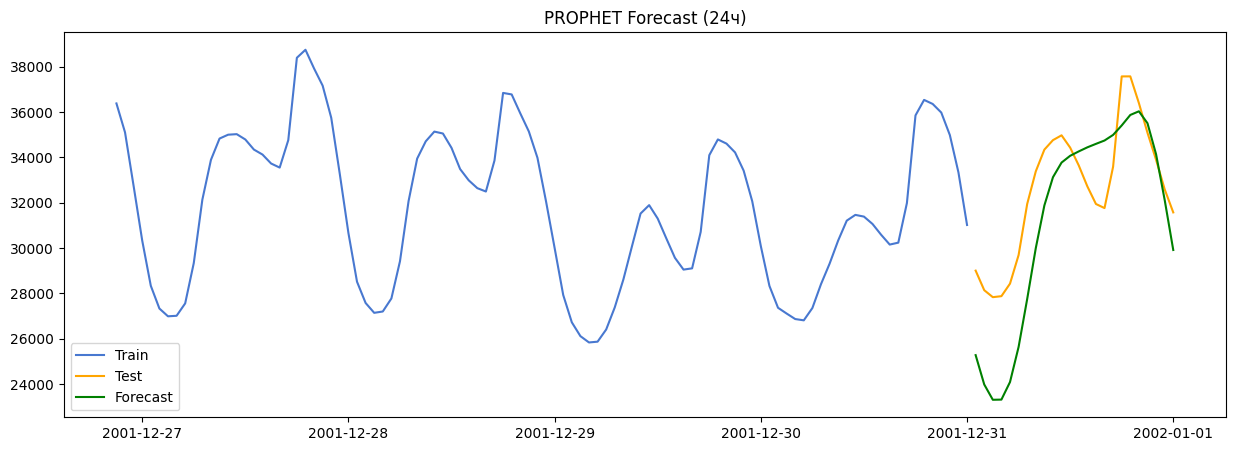

PROPHET | 24ч → MAE=2291.68, RMSE=2732.92, MAPE=7.40%


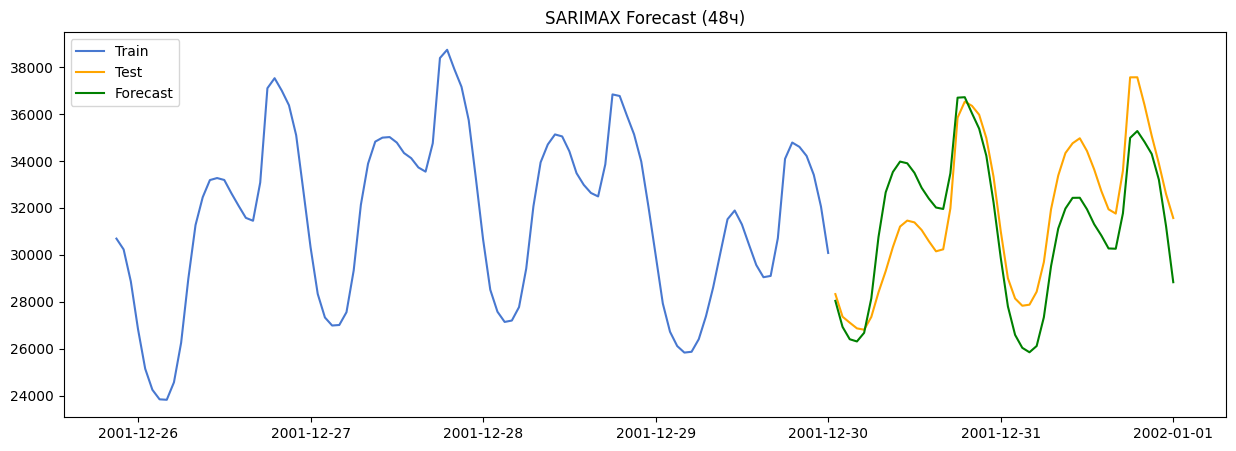

SARIMAX | 48ч → MAE=1659.66, RMSE=1855.78, MAPE=5.24%


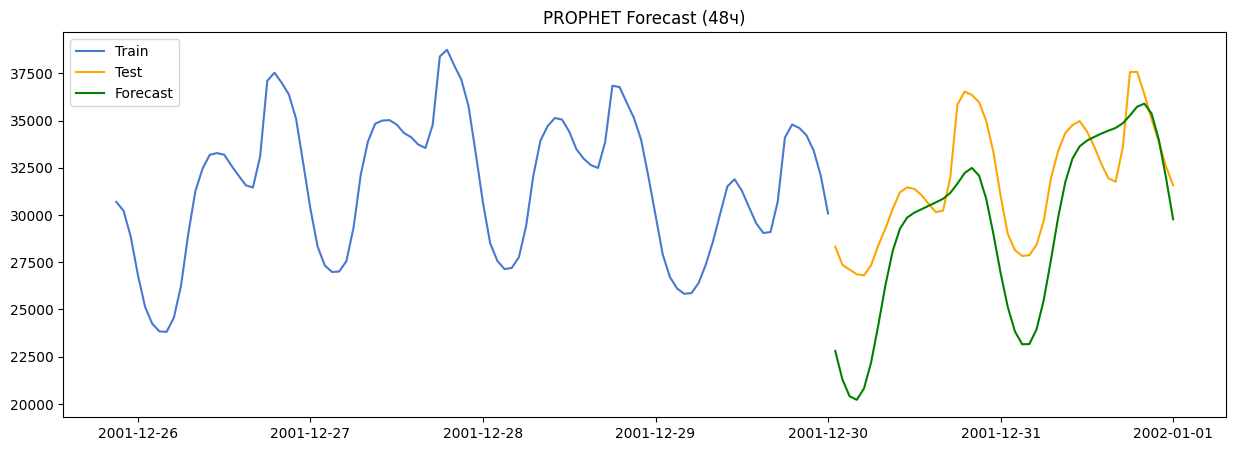

PROPHET | 48ч → MAE=2879.94, RMSE=3439.49, MAPE=9.46%


Model,PROPHET,SARIMAX
Horizon,,
24,0.074029,0.027819
48,0.094557,0.052404


In [16]:
results = []

for name, df in predictions.items():
    # Определяем параметры из ключа
    parts = name.split('_')  # ["pred", "24", "sarimax"]
    horizon = int(parts[1])
    model = parts[2].upper()  # SARIMAX или PROPHET

    # Восстанавливаем test
    train, test = train_test_split(pjm_df, test_size=horizon)

    # Готовим прогноз
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    forecast = df.set_index('Datetime')['Forecast']

    # Визуализация
    plot_forecast(train['PJM_Load_MW'], test['PJM_Load_MW'], forecast,
                  title=f"{model} Forecast ({horizon}ч)")

    # Метрики
    mae, rmse, mape = evaluate(test['PJM_Load_MW'], forecast)
    print(f"{model} | {horizon}ч → MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2%}")

    results.append({
        'Horizon': horizon,
        'Model': model,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

comparison_df = pd.DataFrame(results)
display(comparison_df.pivot(index='Horizon', columns='Model', values='MAPE'))

# Вывод:

* Модель SARIMAX показала более высокую точность на обоих горизонтах, особенно на 24 часах, где ошибка почти в 3 раза ниже.

* Модель Prophet даёт сглаженный прогноз и не всегда точно улавливает пики и резкие перепады нагрузки. Это видно на графиках — особенно при росте и падении спроса.

* Также SARIMAX лучше справляется с краткосрочной сезонностью — это ожидаемо, так как модель явно использует параметры сезонного порядка (S).

### В качестве итога:

__SARIMAX__ является оптимальным выбором (прогнозирование до 48 часов):

* У нее высокая точность (MAPE < 6%)

* Улавливает суточные циклы и пики

* Подходит для высокочастотных рядов с регулярными паттернами

__Prophet__ — хорош как быстрый и интерпретируемый baseline, но уступает по качеству на коротких горизонтах.

### Рекомендации:

1. Использовать SARIMAX для оперативного (1–2 дня) прогноза нагрузки.

2. Prophet — как вспомогательный инструмент или модель для быстрого анализа.

Для долгосрочного прогноза (неделя и более) — стоит использовать нейросети с GPU-ускорением в отдельном ноутбуке (LSTM на KAGGLE).